<a href="https://colab.research.google.com/github/AEInha/Linear-Algebra/blob/main/ase2010_applied_linear_algebra_homework_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASE2010 Applied linear algebra: Homework \#7
$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE2010: Applied linear algebra, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

<br>

---
## Flight data reconstruction



<br>

We are given a scalar time series $y_t$, $t = 1,\dots,n$, assumed to consist of an underlying slowly varying trend $x_t$ and a more rapidly varying random component $z_t$. Our goal is to estimate the trend component $x_t$ or, equivalently, estimate the random component $z_t = y_t - x_t$. This can be considered as an optimization problem with two competing objectives: We want $x_t$ to be smooth, and we want $z_t$ (our estimate of the random component, sometimes called the residual) to be small. In some contexts, estimating $x_t$ is called _smoothing_ or _filtering_.

<br>

For example, running the following cell returns a set of flight data recorded from a simulated flight of an aircraft. Specifically, `y` contains the angle of attack of the aircraft in degrees measured from a noisy sensor at timesteps given in `time`. Some of the data samples were lost and tha validity of the data is noted at the array `validity` (the value `False` implies that the data at the corresponding time is lost and should be considered invalid).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("https://jonghank.github.io/ase2010/files/flight_data_corrupted.csv")
time = df['Time'].values
y = df['Total angle of attack'].values
validity = df['check'].values
df.head(20)

,Time,Position_N,Position_E,Position_D,Flight path angle,Heading angle,Total angle of attack,Bank angle,Ground speed,Lateral acceleration (command),...,Bank angle (response),Drag force,Thrust force,Gravitational acceleration,Yaw,Pitch,Roll,Elevation,Azimuth,check
0,0.00,55.005011,0.536913,-1868.460741,-0.103162,1.908446,0.126335,0.151702,254.587928,2.638698,...,-0.163209,96549.499903,283359.959312,9.748550,1.983945,-0.421522,0.443744,11.687808,-1.799437,True
1,0.01,-110.283126,1.059736,-1818.905048,-0.029843,2.040806,-0.139267,-0.203987,239.537515,2.541756,...,-0.081214,95040.555411,290421.942233,10.218011,1.982488,-0.096032,-0.440203,11.311827,-2.073190,True
2,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
3,0.03,94.628031,0.695827,-1851.675473,-0.274252,1.899385,-0.068329,-0.279113,253.203607,2.612910,...,-0.269807,94733.135157,283113.607669,10.121949,1.992223,-0.428790,0.321779,10.764015,-2.108597,True
4,0.04,85.989345,1.769041,-1951.048143,-0.016099,2.051501,0.496495,-0.183974,256.279537,2.514960,...,0.077175,90329.763471,274790.679222,9.973913,1.978867,-0.922593,-0.168985,10.805964,-1.823342,True
5,0.05,-8.450086,1.088868,-1870.825518,0.134064,2.041622,-0.196838,-0.323338,253.051240,2.582319,...,-0.254543,96934.505218,280461.127737,9.462496,2.033034,-0.134289,-0.612730,12.014642,-2.057017,True
6,0.06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
7,0.07,107.613307,2.170399,-1826.672416,-0.099284,2.065153,0.041041,-0.520055,251.290935,2.452703,...,-0.417593,97709.037733,286726.379628,9.760878,2.028575,0.153582,-0.772879,10.653007,-1.983000,True
8,0.08,330.127794,0.282693,-1864.025941,-0.219342,2.031134,0.677237,-0.867749,258.376881,2.453165,...,-0.689719,95349.665133,271627.851028,10.002768,1.963657,0.686379,-1.191117,12.004601,-2.142520,True
9,0.09,128.603779,1.040151,-1887.483171,-0.090208,2.006767,0.742770,-0.829295,251.969889,2.556874,...,-1.133152,97265.317230,275089.775426,9.901765,1.998511,0.819135,-0.816283,11.182176,-2.108671,True


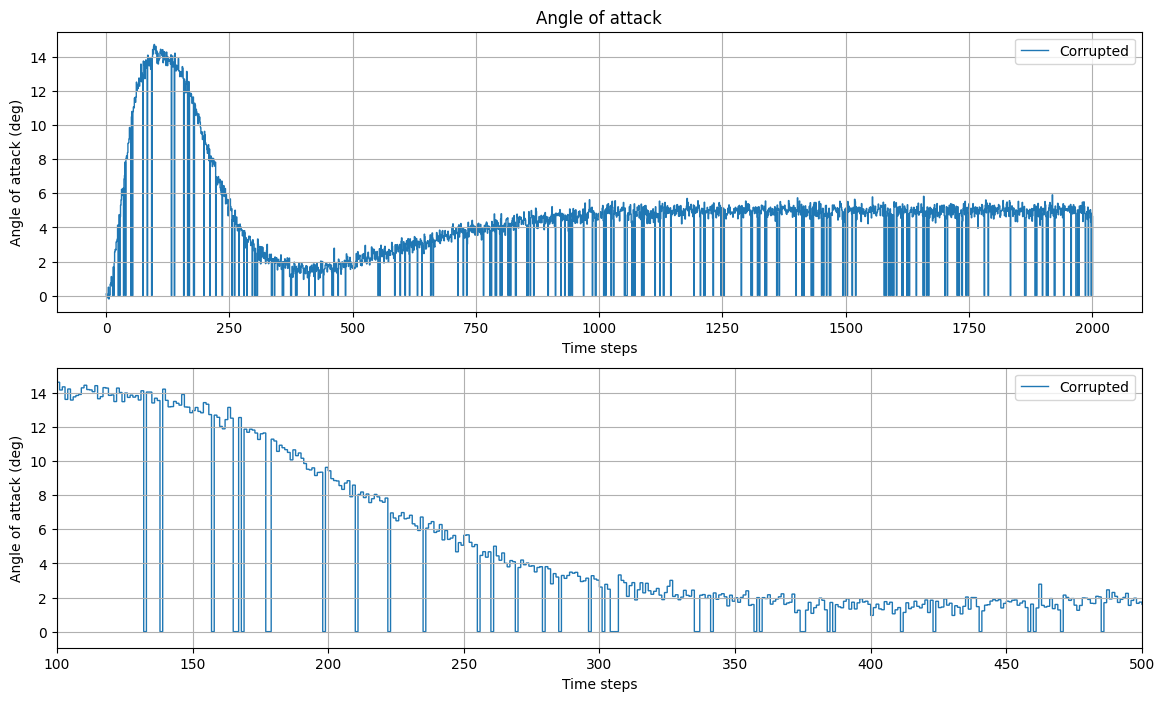

In [2]:
plt.figure(figsize=(14,8),dpi=100)
plt.subplot(211)
plt.stairs(y, label='Corrupted')
plt.grid()
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Angle of attack (deg)")
plt.title("Angle of attack")
plt.subplot(212)
plt.stairs(y, label='Corrupted')
plt.grid()
plt.legend()
plt.xlim(100,500)
plt.xlabel("Time steps")
plt.ylabel("Angle of attack (deg)")
plt.show()

<br>

Reading the trend out from given time-series data can be formulated by following. The underlying trend $x_t$ should explain the valid observed data $y_t$, at the same time we expect the trend (inclination) wouldn't change frequently, so we would like to find $x_1,\dots,x_n$ such that

- $x_t-y_t$ is small for valid $t$ among $t=1,\dots,n$
- $\left(x_{t+2}-x_{t+1}\right)-\left(x_{t+1}-x_{t}\right)$ is small for $t=1,\dots,n-2$

for which we formulate the optimization problem by

$$
\begin{aligned}
  \underset{x_1,\dots,x_n}{\minimize} \quad & \sum_{t=1}^{n}v_t^2\left(x_t-y_t\right)^2  
  + \lambda\sum_{t=1}^{n-2}\left(x_{t+2}-2x_{t+1}+x_t\right)^2
\end{aligned}
$$

with some positive $\lambda$ and $y_t$, $t = 1,\dots,n$ defined as follows.

$$
v_t =
\begin{cases}
0 & \text{if data at time step $t$ is invalid} \\
1 & \text{otherwise}
\end{cases}
$$


This is equivalent to

$$
\begin{aligned}
  \underset{x}{\minimize} \quad & \|V(x-y)\|_2^2 + \lambda\|Dx\|_2^2
\end{aligned}
$$

where $x = (x_1, \dots, x_n)$, $y = (y_1, \dots, y_n )$, with some $V$ and $D$.


<br>

_**(Problem 1)**_ What are $V$ and $D$? Explain how you can build $V$ and $D$. Also explain how you can find the optimal solution $x_1,\dots,x_n$, for the problem.


<br>

- your answer here

\begin{align*}
\vdots\\
\vdots\\
\vdots
\end{align*}

- your answer here


<br>

_**(Problem 2)**_ Compute the optimal solution $x_1,\dots,x_n$, for $\lambda=10^{-2}, 10^0, 10^2, 10^4, 10^6, 10^8$, and explain what you observed from the results with different $\lambda$.

In [38]:
# your answer here
import numpy as np


def make_V(y):
  n = len(y)
  V = np.zeros((n,n))
  for i in range(n):
    if y[i] == float(0):
      V[i,i] = 0
    else:
      V[i,i] = 1
  return V

def make_D(y):
  n = len(y)
  D= np.zeros((n-2,n))
  for i in range(n-2):
    D[i][i] = 1
    D[i][i+1] = -2
    D[i][i+2] = 1
  return D

In [64]:
V = make_V(y)
D = make_D(y)
X = {}
for i in range(-2,10,2):
  weight = 10**(i)
  A_new = np.vstack((V,np.sqrt(weight)*D))
  b_new = np.hstack((V@y,np.zeros(len(D))))
  X[i] = np.linalg.lstsq(A_new, b_new)[0]

<ipython-input-64-c2c9ee524de3>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X[i] = np.linalg.lstsq(A_new, b_new)[0]


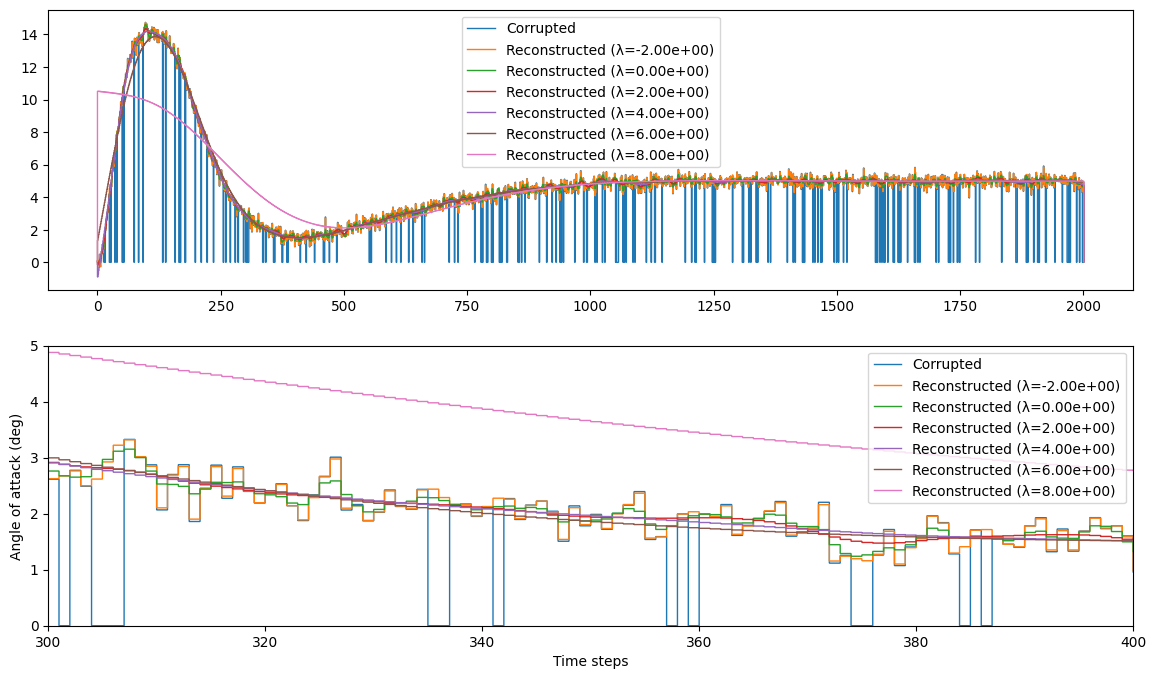

In [70]:
# your answer here
plt.figure(figsize=(14,8),dpi=100)
plt.subplot(211)
plt.stairs(y, label='Corrupted')
for i in range(-2,10,2):
  plt.stairs(X[i],label=f'Reconstructed (λ={i:.2e})')
  plt.grid()
  plt.legend()



plt.subplot(212)
plt.stairs(y, label='Corrupted')
for i in range(-2,10,2):
  plt.stairs(X[i], label=f'Reconstructed (λ={i:.2e})')
  plt.grid()
  plt.legend()


plt.xlim(300,400)
plt.ylim(0,5)
plt.xlabel("Time steps")
plt.ylabel("Angle of attack (deg)")
plt.show()